In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn

In [18]:
from datasets import load_dataset

dataset = load_dataset("glue", "cola")
print(dataset)
dataset_train = dataset['train']
dataset_test = dataset['test']
sentences_train = dataset_train['sentence']
labels_train = dataset_train['label']
sentences_test = dataset_train['sentence']
labels_test = dataset_train['label']


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})


In [19]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print(sentences_train[0])
print(tokenizer.tokenize(sentences_train[0]))
print(tokenizer(sentences_train[0]))

Our friends won't buy this analysis, let alone the next one we propose.
['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
{'input_ids': [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [20]:
input_ids = []
attention_mask = []

for sent in sentences_train:
    encode_dict = tokenizer.encode_plus(
        sent,
        max_length=64,
        # pad_to_max_length=True,
        padding="max_length",
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt',
    )
    
    input_ids.append(encode_dict['input_ids'])
    attention_mask.append(encode_dict['attention_mask'])
    
input_ids = torch.cat(input_ids, dim=0)
attention_mask = torch.cat(attention_mask, dim=0)
labels = torch.tensor(labels_train)


In [41]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split


dataset = TensorDataset(input_ids, attention_mask, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

7,695 training samples
  856 validation samples


In [22]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)
model.cuda()

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_step=len(train_dataset) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=total_step)

/home/qangviet/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
import random

seed_val = 22
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [26]:
training_stats = []

device=torch.device('cuda')

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print("======== Epoch {:} / {:} =====".format(epoch_i + 1, epochs))
    print("Traning...")
    
    t0 = time.time()
    
    total_train_loss = 0
    
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if(step % 40 == 0 and not step == 0):
            elapsed = format_time(time.time() - t0)
            
            print('   Batch {:>5,} of {:>5,}.       Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        
        output_classifier = model(b_input_ids, token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output_classifier.loss
        total_train_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    #Validation
    t0 = time.time()
    
    print("")
    print("Validation ...")
    
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
       
        with torch.no_grad():        
            output_classifier = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = output_classifier.loss
            logits = output_classifier.logits    
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 =====
Traning...
   Batch    40 of   241.       Elapsed: 0:00:29
   Batch    80 of   241.       Elapsed: 0:00:58
   Batch   120 of   241.       Elapsed: 0:01:26
   Batch   160 of   241.       Elapsed: 0:01:55
   Batch   200 of   241.       Elapsed: 0:02:24
   Batch   240 of   241.       Elapsed: 0:02:52

  Average training loss: 0.50
  Training epoch took: 0:02:53

Validation ...
  Accuracy: 0.81
  Validation Loss: 0.41
  Validation took: 0:00:07

======== Epoch 2 / 3 =====
Traning...
   Batch    40 of   241.       Elapsed: 0:00:28
   Batch    80 of   241.       Elapsed: 0:00:57
   Batch   120 of   241.       Elapsed: 0:01:25
   Batch   160 of   241.       Elapsed: 0:01:53
   Batch   200 of   241.       Elapsed: 0:02:22
   Batch   240 of   241.       Elapsed: 0:02:51

  Average training loss: 0.30
  Training epoch took: 0:02:51

Validation ...
  Accuracy: 0.82
  Validation Loss: 0.45
  Validation took: 0:00:07

======== Epoch 3 / 3 =====
Traning...
   Batch    40 

In [28]:
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.498275,0.413674,0.812886,0:02:53,0:00:07
2,0.298627,0.445994,0.823688,0:02:51,0:00:07
3,0.180542,0.580569,0.821759,0:02:54,0:00:07


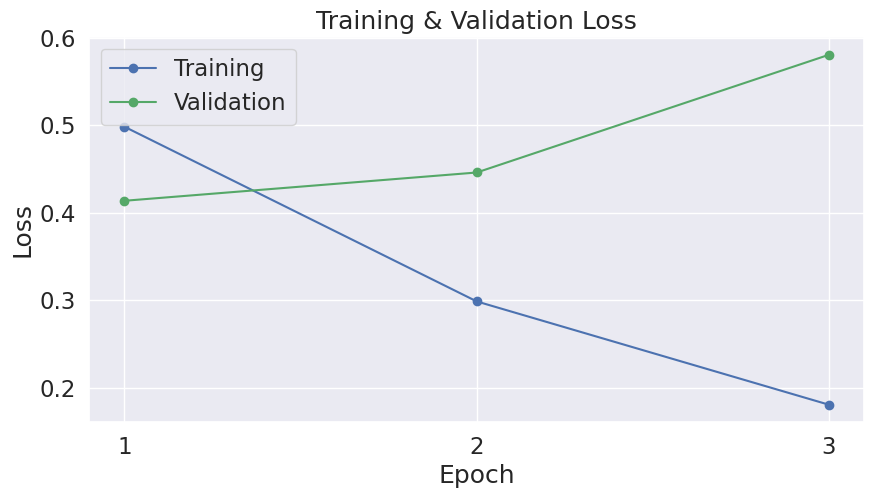

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [40]:
#TEST
test_input_ids = []
test_attention_mask = []

for sent in sentences_test:
    encode_dict = tokenizer.encode_plus(
        sent,
        max_length=64,
        padding="max_length",
        return_attention_mask = True, 
        return_tensors = 'pt', 
    )
    test_input_ids.append(encode_dict['input_ids'])
    test_attention_mask.append(encode_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_mask = torch.cat(test_attention_mask, dim=0)
test_labels = torch.tensor(labels_test)

pred_data = TensorDataset(test_input_ids, test_attention_mask, test_labels)
pred_sample = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, batch_size=batch_size, sampler=pred_sample)

In [36]:
print(test_input_ids.shape)

torch.Size([8551, 64])


In [42]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()
preds, true_labels = [], []

for batch in pred_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
        
    logits = outputs[0]
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true_labels.append(label_ids)
print('    DONE.')

Predicting labels for 8,551 test sentences...
    DONE.


In [54]:
from sklearn.metrics import matthews_corrcoef
print("")
print("Calculating Matthews Corr")

flat_preds = np.concatenate(preds, axis=0)
flat_preds = np.argmax(flat_preds, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_preds)

print("Total MCC: %3f" % mcc)


Calculating Matthews Corr
Total MCC: 0.894359
